## Map Reduce

```
START
  ↓
ORCHESTRATOR (splits PDF into chunks)
  ↓ ↓ ↓ ↓ ↓ (parallel)
MAP 0   MAP 1   MAP 2 ... MAP N
  ↓ ↓ ↓ ↓ ↓
REDUCE (merge summaries)
  ↓
END
```


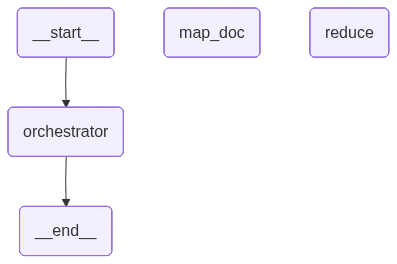

In [28]:
# langgraph_mapreduce_wordcount.py
from typing import TypedDict, List, Dict, Annotated
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver

# ---- State types ----
class AggregateState(TypedDict, total=False):
    docs: List[str]
    # Annotate partials with a reducer (list concatenation)
    partials: Annotated[List[Dict[str,int]], add]
    final_counts: Dict[str,int]

class WorkerState(TypedDict):
    doc: str

# ---- Orchestrator: fan-out map jobs ----
def orchestrator(state: AggregateState) -> Command:
    docs = state.get("docs", []) or []
    sends = [Send("map_doc", {"doc": d}) for d in docs]
    # return a Command that dispatches multiple Sends
    return Command(update={}, goto=sends)

# ---- Map node: count words in a single document ----
def map_doc(state: WorkerState) -> Dict[str, List[Dict[str,int]]]:
    text = state.get("doc", "")
    counts: Dict[str,int] = {}
    for token in text.split():
        w = token.lower().strip(".,!?:;\"'()[]")
        if not w:
            continue
        counts[w] = counts.get(w, 0) + 1
    # return as a one-element list under 'partials' so reducer concatenates lists
    return {"partials": [counts]}

# ---- Reduce node: combine all partial counts ----
def reducer(state: AggregateState) -> Dict[str, Dict[str,int]]:
    final: Dict[str,int] = {}
    for part in state.get("partials", []):
        for word, cnt in part.items():
            final[word] = final.get(word, 0) + cnt
    return {"final_counts": final}

# ---- Build graph ----
def build_mapreduce_graph() -> StateGraph:
    builder = StateGraph(AggregateState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_doc", map_doc)
    builder.add_node("reduce", reducer)

    builder.add_edge(START, "orchestrator")
    # map_doc results feed into reduce
    builder.add_edge("map_doc", "reduce")
    builder.add_edge("reduce", END)

    graph = builder.compile(checkpointer=InMemorySaver())
    return graph

graph= build_mapreduce_graph()

graph



In [29]:
# ---- Run example ----
if __name__ == "__main__":
    # docs = [
    #     "Hello world hello",
    #     "World of code and Hello",
    #     "Another document. Code world!"
    # ]
    
    docs= [
        "Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        "Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        "Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining."
    ]
    initial_state: AggregateState = {
        "docs": docs,
        "partials": [],
        "final_counts": {}
    }

    graph = build_mapreduce_graph()
    config = {"configurable": {"thread_id": "mapreduce_example_1"}}

    # invoke the graph (runs the orchestrator -> map -> reduce)
    graph.invoke(initial_state, config=config)

    # get the final StateSnapshot
    snapshot = graph.get_state(config)

    # IMPORTANT: snapshot is a StateSnapshot object — values are in snapshot.values
    final_counts = snapshot.values.get("final_counts", {})

    print("Final word counts:", final_counts)


Final word counts: {'peak': 2, 'performance': 2, 'gym': 5, 'was': 1, 'founded': 1, 'in': 2, '2015': 1, 'by': 1, 'former': 1, 'olympic': 1, 'athlete': 1, 'marcus': 2, 'chen': 1, 'with': 4, 'over': 1, '15': 1, 'years': 1, 'of': 3, 'experience': 1, 'professional': 1, 'athletics': 1, 'established': 1, 'the': 2, 'to': 4, 'provide': 1, 'personalized': 1, 'fitness': 1, 'solutions': 1, 'for': 2, 'people': 1, 'all': 2, 'levels': 1, 'spans': 1, '10,000': 1, 'square': 1, 'feet': 1, 'and': 5, 'features': 1, 'state-of-the-art': 1, 'equipment': 2, 'is': 1, 'open': 1, 'monday': 1, 'through': 1, 'friday': 1, 'from': 1, '5:00': 1, 'am': 2, '11:00': 1, 'pm': 2, 'on': 3, 'weekends': 1, 'our': 2, 'hours': 1, 'are': 2, '7:00': 1, '9:00': 1, 'we': 2, 'remain': 1, 'closed': 1, 'major': 1, 'national': 1, 'holidays': 2, 'members': 1, 'premium': 2, 'access': 3, 'can': 1, 'enter': 1, 'using': 1, 'their': 1, 'key': 1, 'cards': 1, '24/7': 2, 'including': 1, 'membership': 1, 'plans': 2, 'include': 1, 'basic': 2, '₹

## From the PDF 

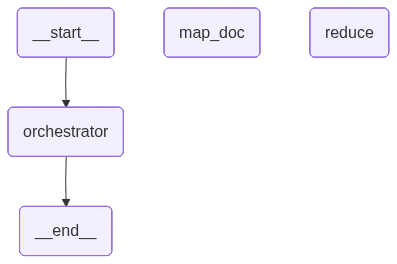

In [15]:
# mapreduce_pdf_wordcount.py
import os
from typing import TypedDict, List, Dict, Annotated
from operator import add

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver

# PDF extraction
from pdfminer.high_level import extract_text

# -----------------------------
# 1. Load PDFs & split into chunks
# -----------------------------

def load_pdfs_as_chunks(folder: str, chunk_size: int = 1500) -> List[str]:
    pdf_files = [f for f in os.listdir(folder) if f.lower().endswith(".pdf")]
    all_chunks = []

    for pdf in pdf_files:
        path = os.path.join(folder, pdf)
        print(f"Reading PDF: {path}")

        raw_text = extract_text(path)
        raw_text = raw_text.replace("\n", " ")

        # Split into chunks
        chunks = []
        words = raw_text.split()
        current = []

        for w in words:
            current.append(w)
            if len(current) >= chunk_size:
                chunks.append(" ".join(current))
                current = []

        if current:
            chunks.append(" ".join(current))

        print(f" -> extracted {len(chunks)} chunks from {pdf}")
        all_chunks.extend(chunks)

    return all_chunks

# -----------------------------
# 2. Map-Reduce State Definitions
# -----------------------------

class AggregateState(TypedDict, total=False):
    docs: List[str]
    partials: Annotated[List[Dict[str,int]], add]
    final_counts: Dict[str,int]

class WorkerState(TypedDict):
    doc: str

# -----------------------------
# 3. Map-Reduce Nodes
# -----------------------------

def orchestrator(state: AggregateState) -> Command:
    docs = state.get("docs", [])
    sends = [Send("map_doc", {"doc": d}) for d in docs]
    return Command(update={}, goto=sends)

def map_doc(state: WorkerState) -> Dict[str, List[Dict[str,int]]]:
    text = state.get("doc", "")
    counts: Dict[str,int] = {}

    for token in text.split():
        w = token.lower().strip(".,!?:;\"'()[]")
        if not w:
            continue
        counts[w] = counts.get(w, 0) + 1

    return {"partials": [counts]}  # reducer will merge lists

def reducer(state: AggregateState) -> Dict[str, Dict[str,int]]:
    final: Dict[str,int] = {}
    for part in state.get("partials", []):
        for w, c in part.items():
            final[w] = final.get(w, 0) + c
    return {"final_counts": final}

# -----------------------------
# 4. Build Graph
# -----------------------------

def build_mapreduce_graph() -> StateGraph:
    builder = StateGraph(AggregateState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_doc", map_doc)
    builder.add_node("reduce", reducer)

    builder.add_edge(START, "orchestrator")
    builder.add_edge("map_doc", "reduce")
    builder.add_edge("reduce", END)

    return builder.compile(checkpointer=InMemorySaver())

graph= build_mapreduce_graph()
graph

In [16]:
# -----------------------------
# 5. Execution
# -----------------------------

if __name__ == "__main__":
    folder = r"C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs"

    print("📄 Loading PDFs...")
    docs = load_pdfs_as_chunks(folder, chunk_size=1000)

    print(f"Total chunks for Map-Reduce: {len(docs)}")

    initial_state: AggregateState = {
        "docs": docs,
        "partials": [],
        "final_counts": {}
    }

    graph = build_mapreduce_graph()
    config = {"configurable": {"thread_id": "pdf_mr_wordcount"}}

    graph.invoke(initial_state, config=config)

    snapshot = graph.get_state(config)
    final_counts = snapshot.values.get("final_counts", {})

    print("\n======================")
    print("📊 FINAL WORD COUNTS:")
    print("======================\n")

    # print top 30 words
    sorted_words = sorted(final_counts.items(), key=lambda x: x[1], reverse=True)
    for w, c in sorted_words[:30]:
        print(f"{w:<20} {c}")


The PDF <_io.BufferedReader name='C:\\Users\\smm931389\\Desktop\\RAG_patterns\\financial_pdfs\\DB_Annual_2023.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


📄 Loading PDFs...
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\DB_Annual_2023.pdf


Cannot set gray non-stroke color because /'P0' is an invalid float value


 -> extracted 381 chunks from DB_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\JPM_Annual_2023.pdf
 -> extracted 208 chunks from JPM_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\Unilever_Annual_2024.pdf
 -> extracted 182 chunks from Unilever_Annual_2024.pdf
Total chunks for Map-Reduce: 771

📊 FINAL WORD COUNTS:

the                  41886
and                  24580
of                   23688
to                   17695
in                   15622
a                    9166
for                  8035
on                   6820
or                   6437
as                   6241
is                   5447
are                  4928
by                   4738
with                 4489
0                    4456
bank                 3899
2023                 3828
that                 3771
risk                 3603
financial            3413
other                3100
our                  3072
at                   2995
$     

## Without Map Reduce:

In [17]:
# sequential_pdf_wordcount.py
import os
import time
from typing import Dict, List
from pdfminer.high_level import extract_text

# --------------------------------------------------------
# 1. Load PDFs and split into chunks
# --------------------------------------------------------

def load_pdfs_as_chunks(folder: str, chunk_size: int = 1500) -> List[str]:
    pdf_files = [f for f in os.listdir(folder) if f.lower().endswith(".pdf")]
    all_chunks = []

    for pdf in pdf_files:
        path = os.path.join(folder, pdf)
        print(f"Reading PDF: {path}")

        raw_text = extract_text(path)
        raw_text = raw_text.replace("\n", " ")

        # Split into chunks
        chunks = []
        words = raw_text.split()
        current = []

        for w in words:
            current.append(w)
            if len(current) >= chunk_size:
                chunks.append(" ".join(current))
                current = []

        if current:
            chunks.append(" ".join(current))

        print(f" -> extracted {len(chunks)} chunks from {pdf}")
        all_chunks.extend(chunks)

    return all_chunks

# --------------------------------------------------------
# 2. Sequential word counting (NO MAP-REDUCE)
# --------------------------------------------------------

def word_count_sequential(chunks: List[str]) -> Dict[str, int]:
    final_counts: Dict[str, int] = {}

    print(f"\nProcessing {len(chunks)} chunks sequentially...")

    for idx, text in enumerate(chunks):
        if idx % 10 == 0:
            print(f"Processing chunk {idx}/{len(chunks)}")

        words = text.split()
        for token in words:
            w = token.lower().strip(".,!?:;\"'()[]")
            if not w:
                continue
            final_counts[w] = final_counts.get(w, 0) + 1

    return final_counts

# --------------------------------------------------------
# 3. Run sequential process and measure time
# --------------------------------------------------------

if __name__ == "__main__":
    folder = r"C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs"

    print("📄 Loading PDFs...")
    chunks = load_pdfs_as_chunks(folder, chunk_size=1000)

    print(f"Total chunks for sequential processing: {len(chunks)}")

    start = time.time()
    final_counts = word_count_sequential(chunks)
    end = time.time()

    print("\n======================")
    print("📊 FINAL WORD COUNTS (Sequential)")
    print("======================\n")

    sorted_words = sorted(final_counts.items(), key=lambda x: x[1], reverse=True)

    for w, c in sorted_words[:30]:
        print(f"{w:<20} {c}")

    print("\n⏱️ TOTAL TIME (Sequential):", round(end - start, 2), "seconds")


The PDF <_io.BufferedReader name='C:\\Users\\smm931389\\Desktop\\RAG_patterns\\financial_pdfs\\DB_Annual_2023.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


📄 Loading PDFs...
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\DB_Annual_2023.pdf
 -> extracted 381 chunks from DB_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\JPM_Annual_2023.pdf


Cannot set gray non-stroke color because /'P0' is an invalid float value


 -> extracted 208 chunks from JPM_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\Unilever_Annual_2024.pdf
 -> extracted 182 chunks from Unilever_Annual_2024.pdf
Total chunks for sequential processing: 771

Processing 771 chunks sequentially...
Processing chunk 0/771
Processing chunk 10/771
Processing chunk 20/771
Processing chunk 30/771
Processing chunk 40/771
Processing chunk 50/771
Processing chunk 60/771
Processing chunk 70/771
Processing chunk 80/771
Processing chunk 90/771
Processing chunk 100/771
Processing chunk 110/771
Processing chunk 120/771
Processing chunk 130/771
Processing chunk 140/771
Processing chunk 150/771
Processing chunk 160/771
Processing chunk 170/771
Processing chunk 180/771
Processing chunk 190/771
Processing chunk 200/771
Processing chunk 210/771
Processing chunk 220/771
Processing chunk 230/771
Processing chunk 240/771
Processing chunk 250/771
Processing chunk 260/771
Processing chunk 270/771
Processing chunk 280/771
Proce

## map reduce with timing:

In [18]:
import os
import time
from typing import TypedDict, List, Dict, Annotated
from operator import add

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver

from pdfminer.high_level import extract_text

# ============================
# 1. Read PDFs → chunks
# ============================

def load_pdfs_as_chunks(folder: str, chunk_size: int = 1500) -> List[str]:
    pdf_files = [f for f in os.listdir(folder) if f.lower().endswith(".pdf")]
    all_chunks = []

    for pdf in pdf_files:
        path = os.path.join(folder, pdf)
        print(f"Reading PDF: {path}")

        raw_text = extract_text(path).replace("\n", " ")

        words = raw_text.split()
        chunks = []
        current = []

        for w in words:
            current.append(w)
            if len(current) >= chunk_size:
                chunks.append(" ".join(current))
                current = []

        if current:
            chunks.append(" ".join(current))

        print(f" -> Extracted {len(chunks)} chunks from {pdf}")
        all_chunks.extend(chunks)

    return all_chunks


# ============================
# 2. Map-Reduce State
# ============================

class AggregateState(TypedDict, total=False):
    docs: List[str]
    partials: Annotated[List[Dict[str,int]], add]
    final_counts: Dict[str,int]

    # timing fields
    map_start: float
    map_end: float
    reduce_start: float
    reduce_end: float


class WorkerState(TypedDict):
    doc: str


# ============================
# 3. Nodes
# ============================

def orchestrator(state: AggregateState) -> Command:
    """Fan-out map tasks"""
    docs = state.get("docs", [])
    sends = [Send("map_doc", {"doc": d}) for d in docs]

    # start MAP phase timer
    return Command(
        update={"map_start": time.time()},
        goto=sends
    )


def map_doc(state: WorkerState) -> Dict[str, List[Dict[str,int]]]:
    """Map: count words in one chunk"""
    text = state.get("doc", "")
    counts: Dict[str,int] = {}

    for token in text.split():
        w = token.lower().strip(".,!?:;\"'()[]")
        if not w:
            continue
        counts[w] = counts.get(w, 0) + 1

    return {"partials": [counts]}


def reducer(state: AggregateState) -> Dict[str, Dict[str,int]]:
    """Reduce: combine all word counts"""
    final: Dict[str,int] = {}

    # end MAP phase when entering reducer
    reduce_start = time.time()
    update_time = {"reduce_start": reduce_start}

    for part in state.get("partials", []):
        for w, c in part.items():
            final[w] = final.get(w, 0) + c

    # mark REDUCE end
    update_time["reduce_end"] = time.time()

    # also mark MAP end only once (safe)
    if "map_end" not in state:
        update_time["map_end"] = reduce_start

    return {**update_time, "final_counts": final}


# ============================
# 4. Build graph
# ============================

def build_mapreduce_graph() -> StateGraph:
    builder = StateGraph(AggregateState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_doc", map_doc)
    builder.add_node("reduce", reducer)

    builder.add_edge(START, "orchestrator")
    builder.add_edge("map_doc", "reduce")
    builder.add_edge("reduce", END)

    return builder.compile(checkpointer=InMemorySaver())


# ============================
# 5. Main execution
# ============================

if __name__ == "__main__":
    folder = r"C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs"

    print("📄 Loading PDFs...")
    docs = load_pdfs_as_chunks(folder, chunk_size=1000)
    print(f"Total chunks: {len(docs)}")

    initial_state: AggregateState = {
        "docs": docs,
        "partials": [],
        "final_counts": {}
    }

    graph = build_mapreduce_graph()
    config = {"configurable": {"thread_id": "pdf_mr_timed"}}

    total_start = time.time()
    graph.invoke(initial_state, config=config)
    total_end = time.time()

    snapshot = graph.get_state(config)
    values = snapshot.values

    # Timings
    map_time = values["map_end"] - values["map_start"]
    reduce_time = values["reduce_end"] - values["reduce_start"]
    total_time = total_end - total_start

    print("\n===============================")
    print("⏱️ MAP-REDUCE TIMING RESULTS")
    print("===============================\n")
    print(f"MAP phase time:      {map_time:.4f} seconds")
    print(f"REDUCE phase time:   {reduce_time:.4f} seconds")
    print(f"TOTAL time:          {total_time:.4f} seconds\n")

    print("Top 30 words:\n")
    final_counts = values["final_counts"]
    for w, c in sorted(final_counts.items(), key=lambda x: x[1], reverse=True)[:30]:
        print(f"{w:<20} {c}")


The PDF <_io.BufferedReader name='C:\\Users\\smm931389\\Desktop\\RAG_patterns\\financial_pdfs\\DB_Annual_2023.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


📄 Loading PDFs...
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\DB_Annual_2023.pdf
 -> Extracted 381 chunks from DB_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\JPM_Annual_2023.pdf


Cannot set gray non-stroke color because /'P0' is an invalid float value


 -> Extracted 208 chunks from JPM_Annual_2023.pdf
Reading PDF: C:\Users\smm931389\Desktop\RAG_patterns\financial_pdfs\Unilever_Annual_2024.pdf
 -> Extracted 182 chunks from Unilever_Annual_2024.pdf
Total chunks: 771

⏱️ MAP-REDUCE TIMING RESULTS

MAP phase time:      0.6603 seconds
REDUCE phase time:   0.0467 seconds
TOTAL time:          0.7325 seconds

Top 30 words:

the                  41886
and                  24580
of                   23688
to                   17695
in                   15622
a                    9166
for                  8035
on                   6820
or                   6437
as                   6241
is                   5447
are                  4928
by                   4738
with                 4489
0                    4456
bank                 3899
2023                 3828
that                 3771
risk                 3603
financial            3413
other                3100
our                  3072
at                   2995
$                    2986


## Notes: 

## Another example

In [27]:
import os
import time
from pdfminer.high_level import extract_text
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv(override=True)

# ------------------------------
# LLM Setup
# ------------------------------
llm = ChatOpenAI(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.2
)

# ------------------------------
# PDF → chunks
# ------------------------------
def load_pdf_chunks(folder: str, chunk_size: int = 1500):
    files = [f for f in os.listdir(folder) if f.endswith(".pdf")]
    all_chunks = []

    for f in files:
        print(f"Reading PDF: {f}")
        text = extract_text(os.path.join(folder, f)).replace("\n", " ")
        words = text.split()
        
        chunk, chunks = [], []
        for w in words:
            chunk.append(w)
            if len(chunk) >= chunk_size:
                chunks.append(" ".join(chunk))
                chunk = []
        if chunk:
            chunks.append(" ".join(chunk))

        print(f" → Extracted {len(chunks)} chunks")
        all_chunks.extend(chunks)

    return all_chunks[:15]  # limit for testing


# ------------------------------
# Sequential summarization
# ------------------------------
def summarize_chunk(text: str):
    prompt = f"Summarize this text:\n{text}"
    return llm.invoke(prompt).content.strip()


def sequential_summarizer(chunks):
    chunk_summaries = []
    timings = []

    print("\n--- Sequential LLM Summaries ---\n")

    t0 = time.time()

    for i, chunk in enumerate(chunks):
        print(f"Summarizing chunk {i+1}/{len(chunks)} ...")
        start = time.time()
        summary = summarize_chunk(chunk)
        end = time.time()

        chunk_summaries.append(summary)
        timings.append(end - start)

        print(f" → Chunk time: {round(end-start, 2)} sec")

    t1 = time.time()

    # Final merge summary
    merge_start = time.time()
    final_summary = llm.invoke(
        f"Combine these summaries into one:\n\n{chunk_summaries}"
    ).content.strip()
    merge_end = time.time()

    print("\n==============================")
    print("SEQUENTIAL SUMMARY TIMINGS")
    print("==============================")
    print(f"Total chunks: {len(chunks)}")
    print(f"Chunk summarization time: {round(t1 - t0, 2)} sec")
    print(f"Final merge summary time: {round(merge_end - merge_start, 2)} sec")
    print(f"TOTAL Sequential Time:   {round(merge_end - t0, 2)} sec")

    return final_summary


# ------------------------------
# RUN
# ------------------------------
if __name__ == "__main__":
    folder = r"C:\Users\smm931389\Desktop\RAG_patterns\test"
    chunks = load_pdf_chunks(folder)

    print(f"\nTotal Chunks: {len(chunks)}\n")

    final = sequential_summarizer(chunks)

    print("\nFINAL SUMMARY:\n", final)


Cannot set gray non-stroke color because /'P0' is an invalid float value


Reading PDF: JPM_Annual_2023.pdf
 → Extracted 139 chunks

Total Chunks: 15


--- Sequential LLM Summaries ---

Summarizing chunk 1/15 ...
 → Chunk time: 1.95 sec
Summarizing chunk 2/15 ...
 → Chunk time: 1.37 sec
Summarizing chunk 3/15 ...
 → Chunk time: 1.5 sec
Summarizing chunk 4/15 ...
 → Chunk time: 1.23 sec
Summarizing chunk 5/15 ...
 → Chunk time: 1.15 sec
Summarizing chunk 6/15 ...
 → Chunk time: 1.05 sec
Summarizing chunk 7/15 ...
 → Chunk time: 1.43 sec
Summarizing chunk 8/15 ...
 → Chunk time: 2.1 sec
Summarizing chunk 9/15 ...
 → Chunk time: 1.19 sec
Summarizing chunk 10/15 ...
 → Chunk time: 1.32 sec
Summarizing chunk 11/15 ...
 → Chunk time: 1.62 sec
Summarizing chunk 12/15 ...
 → Chunk time: 1.06 sec
Summarizing chunk 13/15 ...
 → Chunk time: 1.39 sec
Summarizing chunk 14/15 ...
 → Chunk time: 1.01 sec
Summarizing chunk 15/15 ...
 → Chunk time: 5.91 sec

SEQUENTIAL SUMMARY TIMINGS
Total chunks: 15
Chunk summarization time: 25.29 sec
Final merge summary time: 15.88 sec
TOT

In [26]:
import os
import time
from typing import List, Dict, TypedDict, Annotated
from operator import add
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send, Command
from langgraph.checkpoint.memory import InMemorySaver
from pdfminer.high_level import extract_text
from dotenv import load_dotenv

load_dotenv(override=True)

# ------------------------------
# LLM Setup
# ------------------------------
llm = ChatOpenAI(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.2
)

# ------------------------------
# PDF → chunks
# ------------------------------
def load_pdf_chunks(folder: str, chunk_size: int = 1500):
    files = [f for f in os.listdir(folder) if f.endswith(".pdf")]
    all_chunks = []

    for f in files:
        print(f"Reading PDF: {f}")
        text = extract_text(os.path.join(folder, f)).replace("\n", " ")
        words = text.split()

        chunk, chunks = [], []
        for w in words:
            chunk.append(w)
            if len(chunk) >= chunk_size:
                chunks.append(" ".join(chunk))
                chunk = []
        if chunk:
            chunks.append(" ".join(chunk))

        print(f" → Extracted {len(chunks)} chunks")
        all_chunks.extend(chunks)

    return all_chunks[:15] # limit for testing


# ------------------------------
# MAP-REDUCE STATE
# ------------------------------
class MRState(TypedDict, total=False):
    docs: List[str]
    partials: Annotated[List[str], add]      # partial summaries
    final_summary: str

    # timers
    map_start: float
    map_end: float
    reduce_start: float
    reduce_end: float


class WorkerState(TypedDict):
    doc: str


# ------------------------------
# Nodes
# ------------------------------
def orchestrator(state: MRState) -> Command:
    docs = state["docs"]
    sends = [Send("map_node", {"doc": d}) for d in docs]

    return Command(
        update={"map_start": time.time()},
        goto=sends
    )


def map_node(state: WorkerState) -> Dict:
    """LLM summarize each chunk"""
    text = state["doc"]
    summary = llm.invoke(f"Summarize:\n{text}").content.strip()
    return {"partials": [summary]}


def reduce_node(state: MRState) -> Dict:
    reduce_start = time.time()

    merged = llm.invoke(
        f"Combine these summaries into one:\n\n{state['partials']}"
    ).content.strip()

    reduce_end = time.time()

    return {
        "final_summary": merged,
        "map_end": state.get("map_end", reduce_start),
        "reduce_start": reduce_start,
        "reduce_end": reduce_end
    }


# ------------------------------
# BUILD GRAPH
# ------------------------------
def build_graph():
    builder = StateGraph(MRState)

    builder.add_node("orchestrator", orchestrator)
    builder.add_node("map_node", map_node)
    builder.add_node("reduce_node", reduce_node)

    builder.add_edge(START, "orchestrator")
    builder.add_edge("map_node", "reduce_node")
    builder.add_edge("reduce_node", END)

    return builder.compile(checkpointer=InMemorySaver())


# ------------------------------
# RUN
# ------------------------------
if __name__ == "__main__":
    folder = r"C:\Users\smm931389\Desktop\RAG_patterns\test"

    chunks = load_pdf_chunks(folder)
    print(f"\nTotal chunks: {len(chunks)}")

    graph = build_graph()
    config = {"configurable": {"thread_id": "mr_summarizer"}}

    total_start = time.time()
    graph.invoke({"docs": chunks, "partials": []}, config=config)
    total_end = time.time()

    snapshot = graph.get_state(config)
    v = snapshot.values

    print("\n==============================")
    print("MAP-REDUCE SUMMARY TIMINGS")
    print("==============================")
    print(f"MAP time:      {round(v['reduce_start'] - v['map_start'], 2)} sec")
    print(f"REDUCE time:   {round(v['reduce_end'] - v['reduce_start'], 2)} sec")
    print(f"TOTAL time:    {round(total_end - total_start, 2)} sec")
    print("==============================\n")

    print("FINAL SUMMARY:\n", v["final_summary"])


Cannot set gray non-stroke color because /'P0' is an invalid float value


Reading PDF: JPM_Annual_2023.pdf
 → Extracted 139 chunks

Total chunks: 15

MAP-REDUCE SUMMARY TIMINGS
MAP time:      7.98 sec
REDUCE time:   16.95 sec
TOTAL time:    24.94 sec

FINAL SUMMARY:
 Here is a comprehensive summary of the provided texts:

JPMorgan Chase released its 2023 annual report, highlighting strong financial performance, commitment to corporate responsibility, and leadership in the financial services industry. The company generated $158.1 billion in total net revenue and $49.6 billion in net income for 2023, with a Return on Tangible Common Equity (ROTCE) of 21%. The company's diversified businesses, including Consumer & Community Banking, Corporate & Investment Bank, Commercial Banking, and Asset & Wealth Management, contributed to its success.

In 2023, JPMorgan Chase extended its #1 leadership positions in retail deposits, credit card sales, and credit card outstandings, adding close to 3.6 million net new customers to the franchise. The company also maintained its